In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cPickle as pickle
%matplotlib inline

from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer

from lasagne import layers, updates

from IPython.display import SVG

import theano
import theano.tensor as T

from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from vgg19 import build_model
# Note: tweaked to use average pooling instead of maxpooling

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [2]:
!nvidia-smi

Wed Sep  9 10:27:11 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 5.319.37   Driver Version: 319.37         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20m          Off  | 0000:05:00.0     Off |                    0 |
| N/A   37C    P0    46W / 225W |       91MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20m          Off  | 0000:42:00.0     Off |                    0 |
| N/A   34C    P8    48W / 225W |       11MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
# build VGG net and load weights
net = build_model()
model_data = pickle.load(open('vgg19.pkl'))
values = model_data['param values']
layers.set_all_param_values(net['prob'], values)


In [3]:
print(net.keys())

['input', 'conv1_1', 'conv1_2', 'pool1', 'conv2_1', 'conv2_2', 'pool2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4', 'pool3', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'pool4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'pool5', 'fc6', 'fc7', 'fc8', 'prob']


In [4]:
model = net
classes = np.array(model_data["synset words"])
mean_value = model_data["mean value"]

In [5]:
draw_to_file(layers.get_all_layers(model['prob']), "vgg.svg")

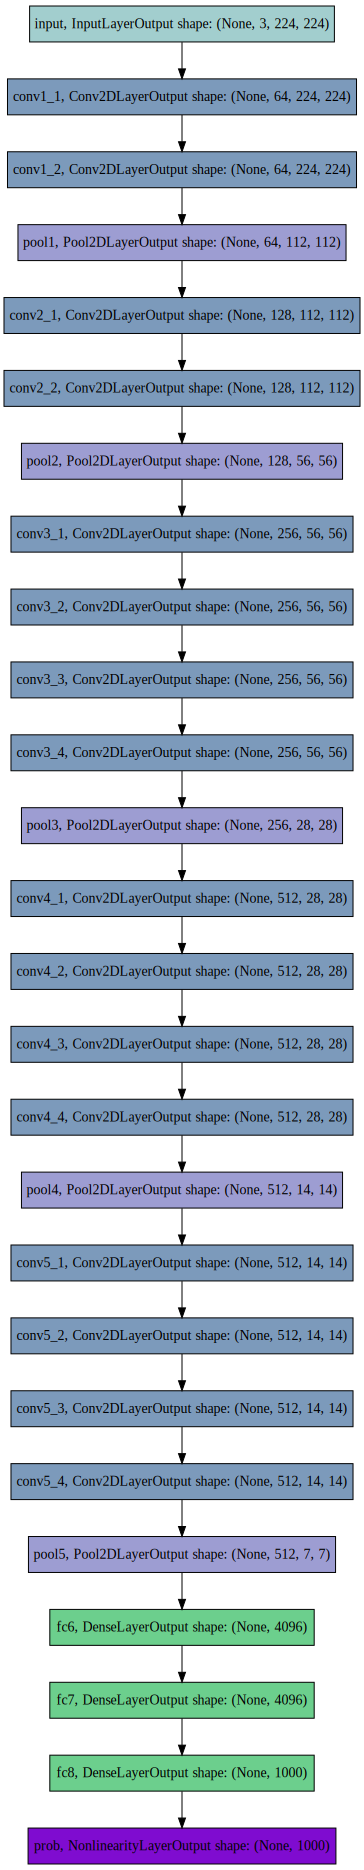

In [8]:
SVG("vgg.svg")

In [6]:
X_batch = theano.tensor.tensor4()
predict = theano.function([X_batch], layers.get_output(model["prob"], X_batch))
pre_predict = theano.function([X_batch], layers.get_output(model["fc8"], X_batch))

In [7]:
!wget http://www.dph.am/sky1024px.jpg --output-document=sample.png

--2015-09-10 09:51:33--  http://www.dph.am/sky1024px.jpg
Resolving www.dph.am... 198.244.107.6
Connecting to www.dph.am|198.244.107.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57024 (56K) [image/jpeg]
Saving to: “sample.png”

100%[======================================>] 57,024       107K/s   in 0.5s    

2015-09-10 09:51:34 (107 KB/s) - “sample.png” saved [57024/57024]



In [8]:
from IPython.display import Image
img = Image("sample.png")

In [9]:
image = imread("sample.png")

In [10]:
X = resize(image, (224, 224), preserve_range=True)
a = X
X =  X
X = X.transpose((2, 1, 0))[np.newaxis, :, :, :]
#X = X[::-1, :, :]
X = X - mean_value[np.newaxis, :, np.newaxis, np.newaxis]
X = X.astype(np.float32)

In [11]:
print(mean_value)

[ 103.939  116.779  123.68 ]


In [12]:
cl_index = list(reversed(np.argsort(predict(X)[0])))

In [13]:
print(cl_index[0:5])

[974, 980, 803, 792, 908]


In [14]:
print(classes[cl_index[0:5]])

['geyser' 'volcano' 'snowplow, snowplough' 'shovel' 'wing']


In [22]:
!nvidia-smi

Tue Sep  8 23:56:36 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 5.319.37   Driver Version: 319.37         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20m          Off  | 0000:05:00.0     Off |                    0 |
| N/A   38C    P0    50W / 225W |      825MB /  4799MB |     36%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20m          Off  | 0000:42:00.0     Off |                    0 |
| N/A   34C    P8    26W / 225W |       11MB /  4799MB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## dream

In [15]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))
theta = 0.000
X_gen = X.copy()

X_gen = np.random.uniform(-128, 128, size=X.shape).astype(np.float32)
#X_gen = np.zeros_like(X)

loss_function = lambda i, act: -((act[0, 0]).sum()) #+ (T.abs_(i)).mean()*0.1

class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        status["pred"] = (pre_predict((dreamer.inputs.get_value()))[0, 0])
        self.model.inputs.set_value((1 - theta) * self.model.inputs.get_value())
        #self.model.inputs.set_value(
        #    gaussian_filter(self.model.inputs.get_value(), 4) * 0.000001+
        #    self.model.inputs.get_value() * 0.999999
        #)
        
        return status
    
batch_optimizer = MyBatchOptimizer(verbose=1,
                                   max_nb_epochs=1000,
                                   whole_dataset_in_device=False,
                                   optimization_procedure=(updates.sgd, 
                                                          {"learning_rate": .01}))
mv = (mean_value[np.newaxis, :, np.newaxis, np.newaxis].astype(np.float32))
dreamer = build_dreamer(
    LightweightModel([model["input"]], 
                     [model["conv1_1"]]),
    X_gen,
    loss_function=loss_function,
    input_type=theano.tensor.tensor4,
    batch_optimizer=batch_optimizer,
    parse_grads=lambda grads:[grad/theano.tensor.abs_(grad).mean() for grad in grads]
)

In [63]:
dreamer.fit(X=X_gen)

  epoch    loss_std    loss_train      pred
-------  ----------  ------------  --------
      0           0  -2.25627e+06  0.953732
  epoch    loss_std    loss_train     pred
-------  ----------  ------------  -------
      1           0  -2.25733e+06  0.95357
  epoch    loss_std    loss_train      pred
-------  ----------  ------------  --------
      2           0  -2.25838e+06  0.953379
  epoch    loss_std    loss_train      pred
-------  ----------  ------------  --------
      3           0  -2.25944e+06  0.953236
  epoch    loss_std    loss_train      pred
-------  ----------  ------------  --------
      4           0   -2.2605e+06  0.953087
  epoch    loss_std    loss_train      pred
-------  ----------  ------------  --------
      5           0  -2.26156e+06  0.952931
  epoch    loss_std    loss_train      pred
-------  ----------  ------------  --------
      6           0  -2.26262e+06  0.952727
  epoch    loss_std    loss_train      pred
-------  ----------  ------------  

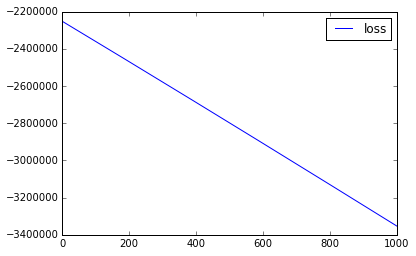

In [60]:
pred = get_stat("pred", dreamer.batch_optimizer.stats)
loss = get_stat("loss_train", dreamer.batch_optimizer.stats)
epoch = get_stat("epoch", dreamer.batch_optimizer.stats)
#plt.plot(epoch, pred, label="pred")
plt.plot(epoch, loss, label="loss")
plt.legend()

(-152.14328, 153.03038)
(-43.31675256347657, 273.77445190429688)


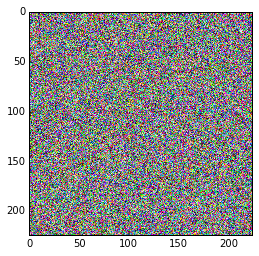

In [61]:
X_gen = dreamer.inputs.get_value(borrow=True)
print(X_gen.min(), X_gen.max())
X_gen_ = X_gen
X_gen = X_gen + mean_value[np.newaxis, :, np.newaxis, np.newaxis]
X_gen = X_gen[:, ::-1, :, :]
print(X_gen.min(), X_gen.max())
X_gen = X_gen.transpose((0, 3, 2, 1))
plt.imshow(X_gen[0])

In [42]:
cl_index = list(reversed(np.argsort(predict(X_gen_.astype(np.float32))[0])))

In [43]:
print(cl_index[0:10])

[611, 539, 794, 741, 775, 735, 721, 750, 411, 599]


## manual

In [30]:
#L = T.sqrt((layers.get_output(model["conv1_1"], X_batch)**2).sum())
L = 0.5*(layers.get_output(model["conv3_2"], X_batch)**2).sum()
get_grad = theano.function([X_batch], theano.grad(L,
                                                  X_batch))
get_loss =  theano.function([X_batch], L)

In [31]:
mv = (mean_value[np.newaxis, :, np.newaxis, np.newaxis].astype(np.float32))

In [32]:
alpha = 1

curve = []
grads_mean = []
grads_std = []
X_gen = np.random.uniform(0, 255, size=X.shape).astype(np.float32)
X_gen -= mv
l = None
#X_gen = np.zeros_like(X)
for i in range(1000):
    g = get_grad(X_gen)
    X_gen += (alpha/ (np.abs(g).mean())) * g 
    #X_gen += alpha * g
    #X_gen += np.random.uniform(size=X.shape)
    #X_gen += alpha * (g - 0.001 * 0.5 * X_gen)
    #X_gen = (1 - 0.00001) * X_gen
    prev_l = l
    l = get_loss(X_gen)
    
    #if prev_l is not None and  l <= prev_l:
    #    alpha /= 2
    curve.append(l)
    if i % 10==0:
        print(l)
    grads_mean.append(g.mean())
    grads_std.append(g.std())
    

74331553792.0
81497391104.0
98133532672.0
1.2234694656e+11
1.532977152e+11
1.90779179008e+11
2.34724524032e+11
2.85172498432e+11
3.42515908608e+11
4.0665153536e+11
4.76609445888e+11
5.5261691904e+11
6.35364704256e+11
7.24975812608e+11
8.21188886528e+11
9.234546688e+11
1.03211604378e+12
1.14746064896e+12
1.26900083098e+12
1.39730839142e+12
1.53265242112e+12
1.67532350669e+12
1.82522989773e+12
1.98220342886e+12
2.14700038554e+12
2.31902753587e+12
2.49867717837e+12
2.68512736051e+12
2.87829340979e+12
3.07917592986e+12
3.28598185574e+12
3.50063794586e+12
3.72196455219e+12
3.95026576179e+12
4.18523329331e+12
4.4281060393e+12
4.67818197811e+12
4.93473287373e+12
5.19858867405e+12
5.47020131533e+12
5.74839010099e+12
6.03518612275e+12
6.32786046157e+12
6.62872470323e+12
6.93805305037e+12
7.25458983322e+12
7.57742593638e+12
7.90883939123e+12
8.2445294633e+12
8.59090609766e+12
8.94588524954e+12
9.30765655245e+12
9.67700591411e+12
1.00537844367e+13
1.04379019428e+13
1.08285520773e+13
1.12279399956

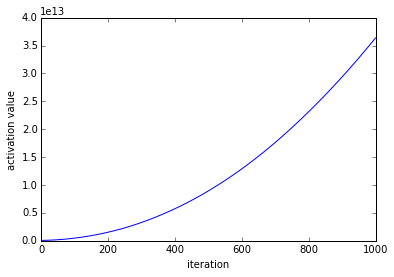

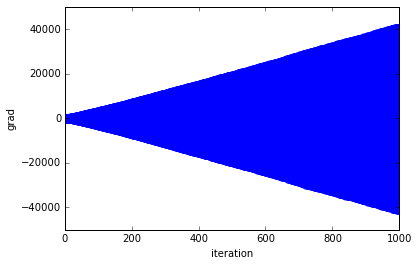

In [33]:
plt.xlabel("iteration")
plt.ylabel("activation value")
plt.plot(curve)
plt.show()
plt.clf()
plt.xlabel("iteration")
plt.ylabel("grad")
plt.errorbar(range(len(grads_mean)), y=grads_mean, yerr=grads_std)
plt.show()

(-4246.8879921874995, 4634.2155234375005)
(1, 224, 224, 3)


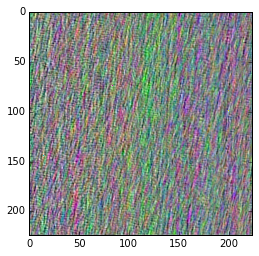

In [36]:
X_gen_ = X_gen
X_gen_ = X_gen_ + mean_value[np.newaxis, :, np.newaxis, np.newaxis]
#X_gen = X_gen[:, ::-1, :, :]
print(X_gen_.min(), X_gen_.max())
X_gen_ = X_gen_.transpose((0, 3, 2, 1))

print(X_gen_.shape)

mn = X_gen_.min(axis=(0, 1, 2))
mx = X_gen_.max(axis=(0, 1, 2))
X_gen_ = (X_gen_ - mn) / (mx - mn)
X_gen_ *= 255.
X_gen_ = np.round(X_gen_)
#print(X_gen_.min(axis=(1, 2))
plt.imshow(X_gen_[0])

In [77]:

cl_index = list(reversed(np.argsort(predict(X_gen.astype(np.float32))[0])))

In [81]:
print(X_gen.max())

5244.6
